In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path


import statsmodels.api as sm

import matplotlib.pyplot as plt


import sys
sys.path.append("D:/analyze_Pearson_residuals")

from  plot_tab_utilities import *



pd.set_option('display.max_columns', 5)

In [2]:
#### user specified
data_folder = r"D:/analyze_Pearson_residuals/"

data_subfolder = "33k_PBMC"

data_path = Path ( data_folder + data_subfolder )

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"


# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 
 
  df_analy['rank_stat'] = df_analy['stat'].rank ( ascending=False )
  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pti = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] == 200 ].max()
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

  arr_unreliability = df_analy['unreliability'].values
  x = np.log10 ( arr_unreliability )
  y = df_analy['abs_log_ratio'].values

  x = sm.add_constant(x)  
  result = sm.OLS(y, x).fit()
  print( '\n\n', result.summary() )

  max_unreliability = np.max ( arr_unreliability )
  max_log10_unreliability = np.log10 ( max_unreliability )  
  ypred_x_max = result.predict( [1, max_log10_unreliability] )
  ypred_x_min = result.predict( [1, 0] )
 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
  
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label, 'abs ( log$_1$$_0$ ( ' + method_symbol + '($\~S$) / ' + method_symbol + '(S) ) )' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 
  y_min2, y_max2 = ax2.get_ylim()

  plot_ax ( df_analy, ax3, 'C', 'unreliability', 'abs_log_ratio', 'unreliability ratio: ' + "$M_g$" + '/' + "$A_g$", \
  'abs ( log$_1$$_0$ ( ' + method_symbol + '($\~S$) / ' + method_symbol + '(S) ) )' , yscale_log=False, line_slope='none' )
  ax3.plot ( [ 1, max_unreliability ], [ ypred_x_min, ypred_x_max ], linewidth=1, color='red')  
  y_min3, y_max3 = ax3.get_ylim()   
 
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max ) 
    
    
  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
    
  return pti

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']

In [6]:
f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()       


df_unreliability = nru_dict['df_gene_stats'] [['A_g', 'M_g']]
df_unreliability = df_unreliability.assign( unreliability = df_unreliability['M_g'] / df_unreliability['A_g'] )
print ( ' df_unreliability:  ' )
print ( '\n', df_unreliability )
print ( '\n\n df_unreliability.describe' )
print ( df_unreliability[['unreliability']].describe ( percentiles=pctl_list ) )


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )

 df_unreliability:  

                         A_g         M_g  unreliability
ENSG00000254709  321.476696  594.080034       1.847972
ENSG00000163736   78.464313   85.392337       1.088295
ENSG00000087086   42.226038   43.064119       1.019848
ENSG00000163220   34.965024   36.166104       1.034351
ENSG00000090382   34.258216   34.801999       1.015873
...                     ...         ...            ...
ENSG00000171241    0.599725    0.599725       1.000000
ENSG00000149573    0.599725    0.722642       1.204955
ENSG00000122025    0.599725    0.651807       1.086843
ENSG00000237980    0.599725    0.682438       1.137918
ENSG00000158488    0.599725    0.666333       1.111065

[12324 rows x 3 columns]


 df_unreliability.describe
       unreliability
count   12324.000000
mean        1.291422
std         0.477563
min         1.000000
1%          1.027981
5%          1.044613
10%         1.056516
25%         1.087649
50%         1.154570
75%         1.311924
90%         1.605470
95%       


  A_g


 df_complementary_stats_Ag

                           0          1
ENSG00000254709  383.323345  18.441670
ENSG00000163736   66.420014  80.181278
ENSG00000087086   42.236462  41.660543
ENSG00000163220   34.057754  34.823828
ENSG00000090382   33.903135  33.696260
...                     ...        ...
ENSG00000154447    0.655159   0.660268
ENSG00000198682    0.655159   0.629280
ENSG00000233038    0.655159   0.702138
ENSG00000073737    0.655159   0.715641
ENSG00000122025    0.655159   0.629280

[10908 rows x 2 columns]


 genes rank_stat_200:  2.2163060863850155


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     74.00
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           8.89e-18
Time:                     

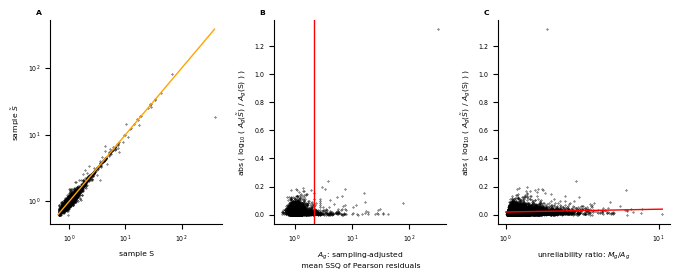

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_A_g_UR = pd.concat ( [ df_A_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Ag = df_A_g_UR.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn ) 
print ( '\n\n Table 3' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)


  L_g


 df_complementary_stats_Lg

                          0          1
ENSEMBL_ID                           
ENSG00000163736  46.790085  46.077720
ENSG00000163220  34.098254  33.776977
ENSG00000087086  32.902598  32.463555
ENSG00000090382  30.894894  30.862072
ENSG00000115523  27.900325  28.609090
...                    ...        ...
ENSG00000198682   0.696335   0.762956
ENSG00000233038   0.681522   0.887475
ENSG00000135549   0.671155   1.625988
ENSG00000155962   0.655804   0.628858
ENSG00000122025   0.654775   0.649210

[10908 rows x 2 columns]


 genes rank_stat_200:  2.648470353610512


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                 1.174e+04
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
T

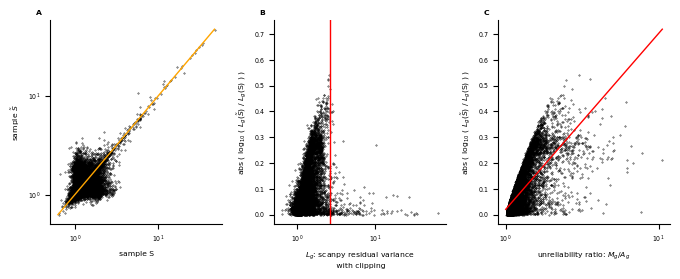

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_L_g_UR = pd.concat ( [ df_L_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Lg = df_L_g_UR.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 
print ( '\n\n Table 5' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)


  S_g


 df_complementary_stats_Sg

                         0         1
gene_vector                        
ENSG00000000419  0.878705  1.142931
ENSG00000000457  0.369437  0.467915
ENSG00000000460  0.096608  0.097640
ENSG00000000938  1.499904  1.528135
ENSG00000000971  0.158584  0.174058
...                   ...       ...
ENSG00000273391  0.101806  0.099243
ENSG00000273428  0.404739  0.377022
ENSG00000273445  1.166690  1.006556
ENSG00000273456  0.108065  0.155072
ENSG00000273472  0.352618  0.301178

[10908 rows x 2 columns]


 genes rank_stat_200:  1.9861293651968595


                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                 1.773e+04
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                     

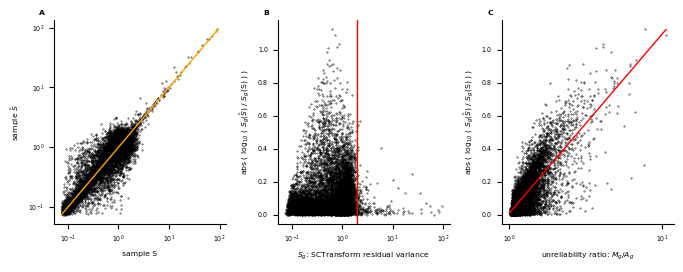

In [9]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_S_g_UR = pd.concat ( [ df_S_g[['stat']], df_unreliability[['unreliability']] ], axis=1 )
df_stats_Sg = df_S_g_UR.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pti = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 
print ( '\n\n Table 7' )
pd.set_option('display.max_columns', 8)
print ( '\n', pti )  
pd.set_option('display.max_columns', 5)